# Purpose
* Instrument: HYSPEC
 - Ei=7meV 
* Sample: K2V3O8
 - A fake sample to show a spin wave

# Running environments

In [ ]:
!hostname

In [ ]:
!which python

In [3]:
# modify this!!!
# working directory. all inputs and outputs will be in this directory
workdir = '/SNS/users/USER/simulations/HYSPEC/spinwave-tut'

In [4]:
mkdir -p {workdir}

In [ ]:
cd {workdir}

# Tools

In [6]:
# %matplotlib notebook
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np, os
import histogram.hdf as hh, histogram as H

In [7]:
import mcvine

# Create workflow

## Sample spec
This is a fake spin-wave model.

In [8]:
%%file kvo.yml
name: kvo
chemical_formula: K2V3O8 #
lattice: 
 constants: 8.87, 8.87, 5.2, 90, 90, 90
 basis_vectors:
  - 8.87, 0, 0
  - 0, 8.87, 0
  - 0, 0, 5.2
excitation:
 type: spinwave
 E_Q: 2.563*sqrt(1-(cos(h*pi)*cos(k*pi))^2)
 S_Q: 1
 Emax: 4
orientation:
 u: 1, 0, 0
 v: 0, 1, 0
shape: block width="5*cm" height="5*cm" thickness="2*mm"
temperature: 300*K

Overwriting kvo.yml


## Create workflow

In [11]:
!mcvine workflow singlecrystal --instrument=hyspec --sample=kvo.yml --outdir=sim --type=DGS 

In [12]:
ls sim

beam/  README.md  sampleassembly/  scattering/


# Beam simulation

In [ ]:
cd {workdir}/sim/beam

## Modify beam simulation script

In [14]:
# check CLI
!mcvine instruments hyspec beam -h


Simulate HYSPEC beam and analyze the beam.

Example:

 $ hyspec_beam --fermi_nu=180 --E=20 --Emin=10 --Emax=39 --LMS=1.8 --ncount=1e8 --nodes=10

For more details of cmd line parameters, run:

 $ hyspec_beam --help-properties




In [15]:
%%file run-beam.sh

# mcvine instruments hyspec beam --keep-in-cache --use-cache --ncount=1e8
mcvine instruments hyspec beam --keep-in-cache --use-cache \
    --ncount=1e9 --E=7 --Emin=5 --Emax=9 --nodes=10

Overwriting run-beam.sh


## Run beam sim
* This will take a while to run

In [ ]:
! ./run-beam.sh >log.run

## Check beam

In [31]:
ls out/

ienergy.h5  ix_divx.h5  ix_y.h5     iy_divy.h5  props.json
itof.h5     ix_divy.h5  iy_divx.h5  neutrons    rank0-step0/


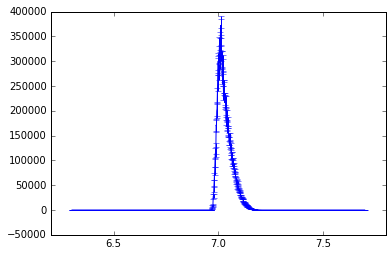

In [32]:
H.plot(hh.load('out/ienergy.h5'))

# Scattering

In [ ]:
cd {workdir}/sim/scattering

In [36]:
ls

scripts/  sim.yml  template/


## Customize sim configuration

In [37]:
%%file sim.yml
cluster:
  nodes: 20
instrument:
  name: hyspec
scatter:
  ncount: 1e6
  buffer_size: 50000
  multiple_scattering: off
  template: ./template

Overwriting sim.yml


## Modify Makefile: HYSPEC need det vessel angle

In [38]:
%%file template/Makefile
# -*- Makefile -*-
# single crystal scan workflow: one angle
#

# *** modifye the following if running mannualy ***
# *** or use command line to change them.       ***
INSTRUMENT=hyspec
DETECTOR_VESSEL_ANGLE=-45.
# NCOUNT=1e7
# BUFFER_SIZE=1000000
# NODES=10

# this will be overide
SAMPLE_ANGLE=0

all: event-nxs

# clean up
clean:
	rm -rf out work-* log.* *~ *.nxs *.h5

# this rule restore this directory back to the original state of template
# don't do this unless you know what you are doing
restore-template: clean
	rm -f beam
	rm -rf sampleassembly
	rm -rf *.nxs *.h5

# 
event-nxs: sim_$(SAMPLE_ANGLE).nxs

# nexus file comes from collecting scattered neutrons at the detector system
sim_$(SAMPLE_ANGLE).nxs: out/scattered-neutrons
	DETECTOR_VESSEL_ANGLE=${DETECTOR_VESSEL_ANGLE} INSTRUMENT=$(INSTRUMENT) NODES=$(NODES) SAMPLE_ANGLE=$(SAMPLE_ANGLE) time ./create-nxs >log.create-nxs 2>&1

# scattered neutrons comes from simulation of scattering of incident beam by sample assembly
out/scattered-neutrons: beam sampleassembly
	NCOUNT=$(NCOUNT) BUFFER_SIZE=$(BUFFER_SIZE) NODES=$(NODES) SAMPLE_ANGLE=$(SAMPLE_ANGLE) ./scatter </dev/null >log.scatter 2>&1

scattering: out/scattered-neutrons

beam:
	ln -s ../../beam

sampleassembly:
	ln -s ../../sampleassembly

Overwriting template/Makefile


## Update sample

In [39]:
# original sample spec
!cat ../sampleassembly/kvo-scatterer.xml

<?xml version="1.0"?>

<!DOCTYPE scatterer>

<!-- weights: absorption, scattering, transmission -->
<homogeneous_scatterer 
  mcweights="0, 1, 0.1"
  max_multiplescattering_loops="3"
  >
  
  <KernelContainer average="yes">


    <!-- a simple kernel for elastic scattering. more realistic kernel exists. -->
    <E_Q_Kernel 
	E_Q="1" 
	S_Q="1"
	Qmin="0./angstrom"
	Qmax="16./angstrom"
	/>


    <!-- kernel for spin wave
      E_Q: expression for E(Q)
      S_Q: expression for E(Q)
      Emax: set this to maximum energy of the spin-wave excitation to help speed up the sim.
      orientation: flattened rotation matrix M. M dot Q_crystal = Q_instrument
     -->
    <E_vQ_Kernel 
	E_Q="pi:=3.1415926535897932; twopi:=2*pi; 
             h:=1.41170434523*Qx+0.0*Qy+0.0*Qz;
             k:=0.0*Qx+1.41170434523*Qy+0.0*Qz;
             l:=0.0*Qx+0.0*Qy+0.827605704078*Qz;
             2.563*sqrt(1-(cos(h*pi)*cos(k*pi))^2)"
	S_Q="pi:=3.1415926535897932; twopi:=2*pi; 
             h:=1.41170434523*Qx

In [ ]:
# new sample spec

In [40]:
%%file ../sampleassembly/kvo-scatterer.xml
<?xml version="1.0"?>

<!DOCTYPE scatterer>

<!-- weights: absorption, scattering, transmission -->
<homogeneous_scatterer 
  mcweights="0, 1, 0.1"
  max_multiplescattering_loops="3"
  >
  
  <KernelContainer average="yes">


    <!-- a simple kernel for elastic scattering. more realistic kernel exists. -->
    <E_Q_Kernel 
	E_Q="0" 
	S_Q="1"
	Qmin="0./angstrom"
	Qmax="16./angstrom"
    absorption_coefficient="13/meter"
    scattering_coefficient="13/meter"
	/>


    <!-- kernel for spin wave
      E_Q: expression for E(Q)
      S_Q: expression for E(Q)
      Emax: set this to maximum energy of the spin-wave excitation to help speed up the sim.
      orientation: flattened rotation matrix M. M dot Q_crystal = Q_instrument
     -->
    <E_vQ_Kernel 
	E_Q="pi:=3.1415926535897932; twopi:=2*pi; 
             h:=1.41170434523*Qx+0.0*Qy+0.0*Qz;
             k:=0.0*Qx+1.41170434523*Qy+0.0*Qz;
             2.563*sqrt(1-(cos(h*pi)*cos(k*pi))^2)"
	S_Q="1"
	Emax="4*meV"
        orientation="0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0"
        absorption_coefficient="13/meter"
        scattering_coefficient="1/meter"
	/>

    
  </KernelContainer>
  
</homogeneous_scatterer>


Overwriting ../sampleassembly/kvo-scatterer.xml


## Test run

In [41]:
! ./scripts/sim.py --angle=3.0

ln -s ../../beam
ln -s ../../sampleassembly
NCOUNT=1e6 BUFFER_SIZE=50000 NODES=20 SAMPLE_ANGLE=3.0 ./scatter </dev/null >log.scatter 2>&1
DETECTOR_VESSEL_ANGLE=-45. INSTRUMENT=hyspec NODES=20 SAMPLE_ANGLE=3.0 time ./create-nxs >log.create-nxs 2>&1


## Run all angles

In [42]:
%%file create-run.py
import numpy as np
ostream = open('run.sh', 'wt')
for a in np.arange(-50, 40.1, .5):
    ostream.write('./scripts/sim.py --angle=%s \n' % a)
    continue
ostream.close()

Writing create-run.py


In [43]:
# create script run.sh
!python create-run.py

In [44]:
# make sure run.sh is executable
!chmod +x run.sh

In [46]:
# run simulation (next cell). this will take a while
# run in a terminal
#  $ tail -f {workdir}/sim/scattering/log.run 
# to monitor the progress

In [45]:
%%script bash
./run.sh &>log.run

In [47]:
ls -1 work*/sim.nxs | wc -l

181


# Reduction

In [1]:
# !mcvine workflow sxr reduce --help

## DGS reduction

In [ ]:
%%time
# reduce tof events to E events
# this takes about 30 minutes
!mcvine workflow sxr reduce --type batch \
    --eaxis -3 6.5 0.1 --psi-axis -50 40.1 .5 --eiguess 7 \
    --eventnxs work_%s/sim.nxs --out reduced_%s.nxs\
    > log.reduce

## Get a slice

In [50]:
%%file slice_H10.yml
Eaxis:
 min: -3
 max: 5.1
 N: 405
Q_projections:
 U:
  proj: 1,0,0
  proj_name: H,0,0
  min: -1
  max: 4.2
  N: 260
 V:
  proj: 0,1,0
  proj_name: 0,K,0
  min: 0.93
  max: 1.07
  N: 1
 W:
  proj: 0,0,1
  proj_name: 0,0,L
  min: -1
  max: 1
  N: 1

Writing slice_H10.yml


In [ ]:
!time mcvine workflow sxr slice \
    --sample {workdir}/kvo.yml \
    --psi-axis -50 40.1 3. \
    --nxs reduced_%s.nxs \
    --slice slice_H10.yml \
    --out slice_H10.nxs \
    > log.slice_H10

In [ ]:
# convert slice nexus to slice histogram
!mcvine workflow sxr slice2hist slice_H10.nxs slice_H10.h5

In [ ]:
# plot slice
H.plot(hh.load("./slice_H10.h5"), min=0, max=1e-5)